# Preparing the Data

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob

def findFiles(path):
    return glob.glob(path)

print(findFiles('data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + ".,;"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )


print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines =open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('data/names/*.txt'):
    category = filename.split('/')[-1].split(".")[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

print(category_lines["French"][:5])

[u'data/names/Irish.txt', u'data/names/French.txt', u'data/names/Japanese.txt', u'data/names/German.txt', u'data/names/Vietnamese.txt', u'data/names/Dutch.txt', u'data/names/Polish.txt', u'data/names/Spanish.txt', u'data/names/Czech.txt', u'data/names/English.txt', u'data/names/Arabic.txt', u'data/names/Korean.txt', u'data/names/Greek.txt', u'data/names/Russian.txt', u'data/names/Chinese.txt', u'data/names/Portuguese.txt', u'data/names/Italian.txt', u'data/names/Scottish.txt']
Slusarski
[u'Abel', u'Abraham', u'Adam', u'Albert', u'Allard']


In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(n_categories + input_size, hidden_size)
        self.lin = nn.Linear(hidden_size, output_size)
        #self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        #self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.softmax = nn.LogSoftmax()

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input), 1)
        #hidden = self.i2h(input_combined)
        #output = self.i2o(input_combined)
        #output_combined = torch.cat((hidden, output), 1)
        output, hidden = self.lstm(input_combined.view(len(input_combined), 1, -1), hidden)
        output = F.dropout(self.lin(output.view(1, -1)), 0.1,  training = self.training)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (Variable(torch.zeros(1, 1, self.hidden_size)),
                Variable(torch.zeros(1, 1, self.hidden_size)))

In [19]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [20]:
# One_hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first(including SOS) to last  letters (not including EOS) for input
def inputTensor(line, train=True):
    if train:
        line = "," + line
    #print(line)
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of first letter (not including SOS) to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(0, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    #print("".join([all_letters[i] for i in letter_indexes]))
    return torch.LongTensor(letter_indexes)
    

In [21]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = Variable(categoryTensor(category))
    input_line_tensor = Variable(inputTensor(line))
    target_line_tensor = Variable(targetTensor(line))
    return category_tensor, input_line_tensor, target_line_tensor

a = randomTrainingExample()


# Training the Network

In [22]:
rnn = RNN(n_letters, 128, n_letters)

In [86]:
criterion = nn.NLLLoss()

learning_rate = 0.001
rnn.train()
print(rnn.training)
def train(category_tensor, input_line_tensor, target_line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size()[0]):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.data[0] / input_line_tensor.size()[0]


True


In [87]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


In [88]:
n_iters = 100000
print_every = 500
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, total_loss / plot_every))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

KeyboardInterrupt: 

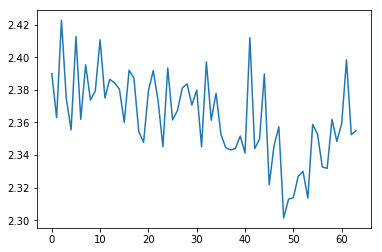

In [64]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

In [65]:
max_length = 20

# Sample from a category and starting letter
def sample(category):
    rnn.eval()
    print(rnn.training)
    category_tensor = Variable(categoryTensor(category))
    input = Variable(inputTensor(',', False))
    print(input.data.size())
    hidden = rnn.initHidden()
    
    output_name = ""
    
    for i in range(max_length):
        output, hidden = rnn(category_tensor, input[0], hidden)
        topv, topi = output.data.topk(1)
        topi = topi[0][0]
        if topi == n_letters - 1:
            break
        else:
            letter = all_letters[topi]
            output_name += letter
        input = Variable(inputTensor(letter, False))
    return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category):
    print(sample(category))
    
samples('Russian')

False
torch.Size([1, 1, 55])
Sharinov


In [66]:
samples('French')

False
torch.Size([1, 1, 55])
Sarte


In [67]:
samples("Italian")

False
torch.Size([1, 1, 55])
Santi


In [55]:
samples("Portuguese")

False
torch.Size([1, 1, 55])
Marra


In [68]:
samples("Japanese")

False
torch.Size([1, 1, 55])
Shimama


In [69]:
samples("Korean")

False
torch.Size([1, 1, 55])
Shong


In [70]:
samples("Dutch")

False
torch.Size([1, 1, 55])
Santer


In [71]:
samples("German")

False
torch.Size([1, 1, 55])
Santer


In [72]:
samples("Polish")

False
torch.Size([1, 1, 55])
Sakanki
